<a href="https://colab.research.google.com/github/jjustinsong/stock-predictor/blob/main/sentiment_analysis_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
filename = 'stock_news.csv'
df = pd.read_csv(filename)
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,headline,label
0,"Markets Close Mostly Lower Again; ROST, PANW R...",Negative
1,"Gap plummets on earnings miss, cuts full-year ...",Negative
2,Billionaire Ken Fisher is Selling These 10 Stocks,Negative
3,"Corning net income drops 13%, shares fall",Negative
4,Internet Explorer shutdown to cause Japan prob...,Negative


## Data Preprocessing

In [6]:
!pip install imbalanced-learn

In [7]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

X = df['headline'].values.reshape(-1, 1)
y = df['label']

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X, y)

df_resampled = pd.DataFrame({'headline': X_resampled.flatten(), 'label': encoder.inverse_transform(y_resampled)})
df_resampled.head()

,headline,label
0,"Markets Close Mostly Lower Again; ROST, PANW R...",Negative
1,"Gap plummets on earnings miss, cuts full-year ...",Negative
2,Billionaire Ken Fisher is Selling These 10 Stocks,Negative
3,"Corning net income drops 13%, shares fall",Negative
4,Internet Explorer shutdown to cause Japan prob...,Negative


<Axes: xlabel='label', ylabel='count'>

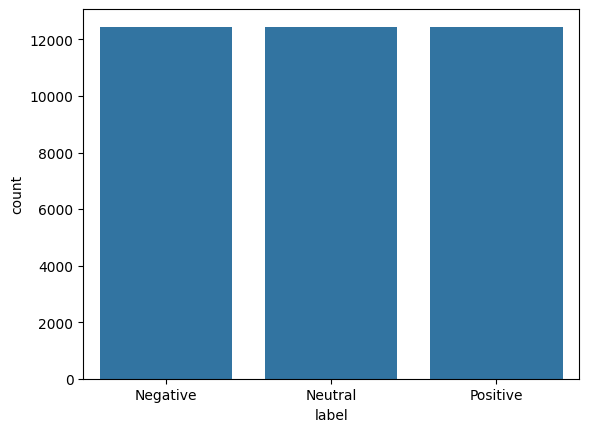

In [8]:
sns.countplot(x='label', data=df_resampled)

In [9]:
X, y = df_resampled['headline'].values, df_resampled['label'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
print(f'shape of train: {X_train.shape}, {y_train.shape}')
print(f'shape of val: {X_val.shape}, {y_val.shape}')
print(f'shape of test: {X_test.shape}, {y_test.shape}')

shape of train: (22406,), (22406,)
shape of val: (7469,), (7469,)
shape of test: (7469,), (7469,)


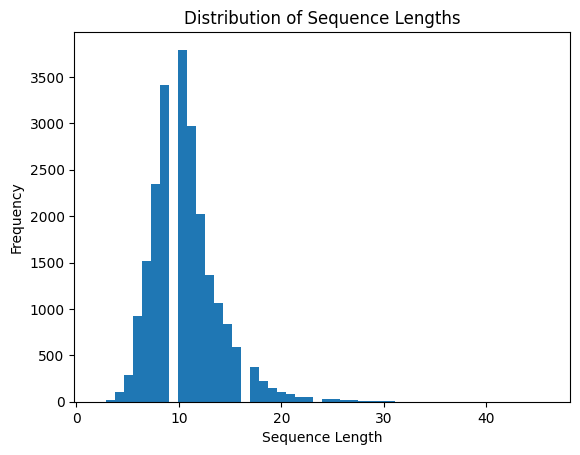

Mean sequence length: 10.687672944746943
Median sequence length: 10.0
Max sequence length: 46


In [10]:
import matplotlib.pyplot as plt

def get_sequence_lengths(texts):
    lengths = []
    for text in texts:
        lengths.append(len(text.split()))
    return lengths

# Get sequence lengths for the training data
sequence_lengths = get_sequence_lengths(X_train)

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Median sequence length: {np.median(sequence_lengths)}")
print(f"Max sequence length: {np.max(sequence_lengths)}")

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
y_train

array(['Negative', 'Negative', 'Positive', ..., 'Negative', 'Neutral',
       'Neutral'], dtype=object)

In [13]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00


In [14]:
import nlpaug.augmenter.word as naw

In [15]:
import torchtext.vocab as vocab

glove = vocab.GloVe(name='6B', dim=100)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21288.26it/s]


In [16]:
embedding_matrix = np.zeros((len(glove.stoi) + 1, 100))
for word, index in glove.stoi.items():
    embedding_matrix[index] = glove.vectors[index]

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [214]:
torch.save(embedding_matrix, 'glove_embeddings.pt')

In [17]:
def preprocess(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with one space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

'''def tokenize(X_train, y_train, X_val, y_val, X_test, y_test):
    vocab = []

    stop_words = set(nltk.corpus.stopwords.words('english'))
    for text in X_train:
        for word in text.lower().split():
            word = preprocess(word)
            if word not in stop_words and word != '':
                vocab.append(word)

    corpus = Counter(vocab)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # tokenize
    final_train, final_val, final_test = [], [], []
    for text in X_train:
        temp = []
        for word in text.lower().split():
            word = preprocess(word)
            if word in onehot_dict.keys():
                temp.append(onehot_dict[word])
        final_train.append(temp)
    for text in X_val:
        temp = []
        for word in text.lower().split():
            word = preprocess(word)
            if word in onehot_dict.keys():
                temp.append(onehot_dict[word])
        final_val.append(temp)
    for text in X_test:
        temp = []
        for word in text.lower().split():
            word = preprocess(word)
            if word in onehot_dict.keys():
                temp.append(onehot_dict[word])
        final_test.append(temp)

    max_length = max(len(seq) for seq in final_train + final_val + final_test)
    final_train = [seq + [0] * (max_length - len(seq)) for seq in final_train]
    final_val = [seq + [0] * (max_length - len(seq)) for seq in final_val]
    final_test = [seq + [0] * (max_length - len(seq)) for seq in final_test]

    label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
    encoded_train = [label_mapping[i] for i in y_train]
    encoded_val = [label_mapping[i] for i in y_val]
    encoded_test = [label_mapping[i] for i in y_test]
    return np.array(final_train), np.array(encoded_train), np.array(final_val), np.array(encoded_val), np.array(final_test), np.array(encoded_test), onehot_dict'''

def tokenize_glove(X_train, X_val, X_test, y_train, y_val, y_test, max_length):
    def get_indices(texts):
        indices = []
        for text in texts:
            temp = []
            for word in text.lower().split()[:max_length]:
                word = preprocess(word)
                if word in glove.stoi:
                    temp.append(glove.stoi[word])
                else:
                    temp.append(0)
            if len(temp) < max_length:
                temp.extend([0] * (max_length - len(temp)))
            indices.append(temp)
        return indices

    final_train = get_indices(X_train)
    final_val = get_indices(X_val)
    final_test = get_indices(X_test)

    label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
    encoded_train = [label_mapping[i] for i in y_train]
    encoded_val = [label_mapping[i] for i in y_val]
    encoded_test = [label_mapping[i] for i in y_test]

    return np.array(final_train), np.array(encoded_train), np.array(final_val), np.array(encoded_val), np.array(final_test), np.array(encoded_test)

In [18]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
import spacy
import random
from nltk.corpus import wordnet
from nltk.corpus import stopwords

try:
    spacy.require_gpu()
except:
    print('GPU not available')

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
synonym_cache = {}

def identify_entities(text):
    doc = nlp(text)
    entities = {ent.text for ent in doc.ents}
    return entities

def get_synonyms(word, pos_tag):
    if word in synonym_cache:
        return synonym_cache[word]
    synonyms = set()
    for syn in wordnet.synsets(word):
        if syn.pos() == pos_tag:
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym != word and synonym not in stop_words:
                    synonyms.add(synonym)
    synonym_cache[word] = list(synonyms)
    return synonym_cache[word]

def replace_word_with_synonym(words, entities):
    new_words = words[:]
    pos_tags = nlp(' '.join(new_words))
    attempts = 0
    while attempts < 10:
        random_idx = random.randint(0, len(new_words) - 1)
        random_word = new_words[random_idx]
        if random_word in entities or random_word.lower() in stop_words:
            attempts += 1
            continue
        pos_tag = pos_tags[random_idx].pos_
        wn_pos = {
            'NOUN': 'n',
            'VERB': 'v',
            'ADJ': 'a',
            'ADV': 'r'
        }.get(pos_tag, None)
        if wn_pos is None:
            attempts += 1
            continue
        synonyms = get_synonyms(random_word, wn_pos)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words[random_idx] = synonym
            break
        attempts += 1
    return new_words

def augment_text_simple(text):
    entities = identify_entities(text)
    words = text.split()
    if len(words) > 1:
        words = replace_word_with_synonym(words, entities)
    augmented_text = ' '.join(words)
    return augmented_text

In [20]:
X_train_augmented = [augment_text_simple(text) for text in X_train]

X_train_augmented = np.array(X_train_augmented)

In [21]:
for i in range(20, 30):
    print(f"Original: {X_train[i]}")
    print(f"Augmented: {X_train_augmented[i]}")
    print("---")

Original: Nancy Altobello Appointed to Board of Directors of Amphenol Corporation
Augmented: Nancy Altobello nominate to Board of Directors of Amphenol Corporation
---
Original: Regions Financial Scheduled to Participate in Deutsche Bank Global Financial Services Conference
Augmented: Regions Financial schedule to Participate in Deutsche Bank Global Financial Services Conference
---
Original: Company News for Jun 7, 2022
Augmented: Company News for Jun 7, 2022
---
Original: Economist: 'Consumer is still out there spending' despite slowing growth, inflation
Augmented: Economist: 'Consumer is stillness out there spending' despite slowing growth, inflation
---
Original: IFF Appoints Nicolas Mirzayantz President of IFFs Nourish Division
Augmented: IFF Appoints Nicolas Mirzayantz President of IFFs Nourish Division
---
Original: Global gas prices: These countries are facing more pain than the U.S.
Augmented: Global gas prices: These countries are facing more pain than the U.S.
---
Original: 

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = tokenize_glove(X_train_augmented, X_val, X_test, y_train, y_val, y_test, 15)

In [23]:
X_train[0]

array([    0,  2250,  9912,  1025,     0, 29019,    25,  3292,     5,
        4361, 14672,  1932,     0,     0,     0])

In [25]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = DataLoader(val_data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_data, shuffle=True, batch_size=64)

## LSTM

In [148]:
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentAnalysisLSTM, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.n_layers = n_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [149]:
X_train

array([[311, 402,   0, ...,   0,   0,   0],
       [ 18, 422,   1, ...,   0,   0,   0],
       [372,  56,   0, ...,   0,   0,   0],
       ...,
       [881, 196, 164, ...,   0,   0,   0],
       [875,  37, 406, ...,   0,   0,   0],
       [ 44,   2, 278, ...,   0,   0,   0]])

In [150]:
y_train.shape

(22406,)

In [151]:
model = SentimentAnalysisLSTM(vocab_size=len(vocab)+1, embedding_dim=64, hidden_dim=256, output_dim=3, n_layers=2, dropout=0.5)
model.to(device)

print(model)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


## LSTM Training

In [159]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

In [70]:
def accuracy(pred, label):
    pred = pred.argmax(dim=1, keepdim=True)
    correct = pred.eq(label.view_as(pred)).sum().item()
    return correct

In [154]:
import torch.optim as optim

In [163]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs):
    '''
    Trains the LSTM model on the training data.
    '''

    #scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=0.00025, step_size_up=15, mode='triangular', cycle_momentum=False)

    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0

        # Sets model to training mode, enabling dropout and batch normalization
        model.train()

        for inputs, targets in train_loader:
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size=batch_size)
            inputs = inputs.to(device)
            targets = targets.to(device)

            h = tuple([each.data for each in h])
            # Reset gradients to prevent accumulation across batches
            model.zero_grad()

            outputs, h = model(inputs, h)

            outputs = outputs.view(batch_size, -1).float()
            outputs = F.softmax(outputs, dim=1)
            targets = targets.long().to(device)

            # Calculates loss by comparing outputs to targets
            loss = loss_function(outputs, targets)

            # Calculates gradient of loss to adjust weights efficiently
            loss.backward()
            train_losses.append(loss.item())

            acc = accuracy(outputs, targets)
            train_acc += acc

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            # Updates weights based on calculated gradients
            optimizer.step()

            #scheduler.step()

        # Validation loop

        val_losses = []
        val_acc = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                val_batch_size = inputs.size(0)
                val_h = model.init_hidden(batch_size=val_batch_size)
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs, val_h = model(inputs, val_h)
                outputs = outputs.view(val_batch_size, -1).float()
                outputs = F.softmax(outputs, dim=1)
                targets = targets.long().to(device)
                val_losses.append(loss_function(outputs, targets).item())
                acc = accuracy(outputs, targets)
                val_acc += acc


        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_acc = train_acc/len(train_loader.dataset)
        val_acc = val_acc/len(val_loader.dataset)


        #current_lr = scheduler.get_last_lr()[0]

        print(f'Epoch {epoch+1}, Loss: {train_loss}, Val loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}')

In [164]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 1.0986218224903117, Val loss: 1.0986792175178854, Train Acc: 0.3341961974471124, Val Acc: 0.3266836256526978
Epoch 2, Loss: 1.09863344794325, Val loss: 1.0986849487337291, Train Acc: 0.33330357939837546, Val Acc: 0.3266836256526978
Epoch 3, Loss: 1.0986064607940849, Val loss: 1.0986839838517017, Train Acc: 0.33549049361778094, Val Acc: 0.3266836256526978
Epoch 4, Loss: 1.0985779378488871, Val loss: 1.098680887466822, Train Acc: 0.33607069534946, Val Acc: 0.3266836256526978
Epoch 5, Loss: 1.0986494980646335, Val loss: 1.0986859309367645, Train Acc: 0.33433009015442294, Val Acc: 0.3266836256526978
Epoch 6, Loss: 1.098558235032606, Val loss: 1.098682977195479, Train Acc: 0.3364723734713916, Val Acc: 0.3266836256526978
Epoch 7, Loss: 1.0986194196250025, Val loss: 1.0986902479432588, Train Acc: 0.3339284120324913, Val Acc: 0.3266836256526978
Epoch 8, Loss: 1.0986228991098215, Val loss: 1.098688028816484, Train Acc: 0.3333482103008123, Val Acc: 0.3266836256526978
Epoch 9, Loss

In [156]:
torch.save(model.state_dict(), 'model_weights.pth')

In [157]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [160]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 1.0987313479779452, Val loss: 1.0987856296392589, Train Acc: 0.3325894849593859, Val Acc: 0.33431516936671574, LR: 0.00015400000000000036
Epoch 2, Loss: 1.0988063034508642, Val loss: 1.0986635297791572, Train Acc: 0.33142908149602784, Val Acc: 0.3266836256526978, LR: 0.00020199999999999933
Epoch 3, Loss: 1.0987573209990802, Val loss: 1.098715950281192, Train Acc: 0.33192002142283317, Val Acc: 0.3266836256526978, LR: 5.8000000000000685e-05
Epoch 4, Loss: 1.0987163259093238, Val loss: 1.0988559824788673, Train Acc: 0.33357136481299654, Val Acc: 0.3266836256526978, LR: 0.00010600000000000137
Epoch 5, Loss: 1.0987369188895593, Val loss: 1.0987588258890004, Train Acc: 0.3354458627153441, Val Acc: 0.3266836256526978, LR: 0.00025
Epoch 6, Loss: 1.0987163687024022, Val loss: 1.0987153756312835, Train Acc: 0.3292421672766223, Val Acc: 0.3266836256526978, LR: 0.00010600000000000137
Epoch 7, Loss: 1.0987099293630007, Val loss: 1.0987757403626401, Train Acc: 0.32973310720342763, Val

In [26]:
torch.save(model.state_dict(), 'model_weights.pth')

In [27]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [28]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.7491782722561574, Val loss: 0.8358887492591499, Train Acc: 0.8010354369365349, Val Acc: 0.7141518275538894
Epoch 2, Loss: 0.743416719786961, Val loss: 0.8374442414850252, Train Acc: 0.805677050789967, Val Acc: 0.7097335654036685
Epoch 3, Loss: 0.7430100861017442, Val loss: 0.8424490988254547, Train Acc: 0.8065250379362671, Val Acc: 0.7045119828624983
Epoch 4, Loss: 0.7390779163289852, Val loss: 0.8325231592369895, Train Acc: 0.811523699009194, Val Acc: 0.7158923550676128
Epoch 5, Loss: 0.7337302023946134, Val loss: 0.8387565921005021, Train Acc: 0.8159867892528787, Val Acc: 0.7086624715490695
Epoch 6, Loss: 0.7332295012712139, Val loss: 0.8312535390385196, Train Acc: 0.8168347763991788, Val Acc: 0.7158923550676128
Epoch 7, Loss: 0.7264537899708442, Val loss: 0.8387917287838764, Train Acc: 0.8233955190573954, Val Acc: 0.710269112330968
Epoch 8, Loss: 0.723689640979794, Val loss: 0.8418867193226122, Train Acc: 0.8260287423011693, Val Acc: 0.7075913776944704
Epoch 9, Loss

In [29]:
torch.save(model.state_dict(), 'model_weights.pth')

In [30]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [31]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.7178106369203575, Val loss: 0.8288966053062015, Train Acc: 0.8320539141301437, Val Acc: 0.7181684295086357
Epoch 2, Loss: 0.7175986544892043, Val loss: 0.8319862884843451, Train Acc: 0.8321878068374543, Val Acc: 0.7173651091176865
Epoch 3, Loss: 0.7165570949521792, Val loss: 0.8257943452932895, Train Acc: 0.833437472105686, Val Acc: 0.7239255589771054
Epoch 4, Loss: 0.7103113857723676, Val loss: 0.8286994091975384, Train Acc: 0.8395965366419709, Val Acc: 0.7187039764359352
Epoch 5, Loss: 0.713575676997616, Val loss: 0.8242432956512158, Train Acc: 0.8370525752030706, Val Acc: 0.7236577855134556
Epoch 6, Loss: 0.7116063777118199, Val loss: 0.8259340196083753, Train Acc: 0.838123716861555, Val Acc: 0.7223189181952069
Epoch 7, Loss: 0.7077249269002515, Val loss: 0.8179074966499948, Train Acc: 0.8422743907881818, Val Acc: 0.7314232159592984
Epoch 8, Loss: 0.7054683053374461, Val loss: 0.8227668559958792, Train Acc: 0.8442381504954031, Val Acc: 0.726469406881778
Epoch 9, Los

In [32]:
torch.save(model.state_dict(), 'model_weights.pth')

In [33]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [34]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.7039631110285216, Val loss: 0.8309391966232886, Train Acc: 0.8465143265196823, Val Acc: 0.7172312223858616
Epoch 2, Loss: 0.7040423974501083, Val loss: 0.8250113188201545, Train Acc: 0.8464696956172454, Val Acc: 0.7239255589771054
Epoch 3, Loss: 0.7013117140438009, Val loss: 0.8313611921591636, Train Acc: 0.8485673480317772, Val Acc: 0.716695675458562
Epoch 4, Loss: 0.6987958802136137, Val loss: 0.8268436050822592, Train Acc: 0.8517807730072302, Val Acc: 0.7208461641451333
Epoch 5, Loss: 0.6990656876530015, Val loss: 0.8188649235118148, Train Acc: 0.851245202177988, Val Acc: 0.7310215557638238
Epoch 6, Loss: 0.696675771483341, Val loss: 0.8310383802805191, Train Acc: 0.8530304382754619, Val Acc: 0.7187039764359352
Epoch 7, Loss: 0.6949750208820664, Val loss: 0.8213736921803564, Train Acc: 0.8554405070070517, Val Acc: 0.7278082742000268
Epoch 8, Loss: 0.6950833248173799, Val loss: 0.8242296846503885, Train Acc: 0.8547710434704989, Val Acc: 0.725398313027179
Epoch 9, Los

In [35]:
torch.save(model.state_dict(), 'model_weights.pth')

In [36]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [37]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6911698418234963, Val loss: 0.8232340985893184, Train Acc: 0.8589663482995626, Val Acc: 0.7252644262953541
Epoch 2, Loss: 0.6900263870833774, Val loss: 0.8222790770551078, Train Acc: 0.8609747389092207, Val Acc: 0.7276743874682019
Epoch 3, Loss: 0.6916482366950978, Val loss: 0.8230403353515853, Train Acc: 0.8586539319825047, Val Acc: 0.727540500736377
Epoch 4, Loss: 0.690792988353381, Val loss: 0.8207869743689512, Train Acc: 0.8592787646166206, Val Acc: 0.7276743874682019
Epoch 5, Loss: 0.6894372040977151, Val loss: 0.8208236350462987, Train Acc: 0.8614210479335892, Val Acc: 0.7279421609318516
Epoch 6, Loss: 0.6894387925912582, Val loss: 0.8267062752165346, Train Acc: 0.8615103097384629, Val Acc: 0.7239255589771054
Epoch 7, Loss: 0.6922258097843165, Val loss: 0.8258385074953748, Train Acc: 0.8578505757386414, Val Acc: 0.72432721917258
Epoch 8, Loss: 0.6902653683779413, Val loss: 0.8189084585915264, Train Acc: 0.8602606444702312, Val Acc: 0.7306198955683492
Epoch 9, Los

In [38]:
torch.save(model.state_dict(), 'model_weights.pth')

In [40]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [41]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6862240272139687, Val loss: 0.8205226776946304, Train Acc: 0.8637864857627421, Val Acc: 0.7282099343955014
Epoch 2, Loss: 0.6812049879157084, Val loss: 0.8175443757293571, Train Acc: 0.8698562884941533, Val Acc: 0.7324943098138974
Epoch 3, Loss: 0.679955709082594, Val loss: 0.8206393191447625, Train Acc: 0.8706150138355797, Val Acc: 0.7292810282501004
Epoch 4, Loss: 0.6798835359354332, Val loss: 0.8138096630573273, Train Acc: 0.8707935374453272, Val Acc: 0.7357075913776945
Epoch 5, Loss: 0.67991999357131, Val loss: 0.8158234233020717, Train Acc: 0.8706596447380166, Val Acc: 0.733967063863971
Epoch 6, Loss: 0.6775253411706607, Val loss: 0.8149887522061666, Train Acc: 0.8728019280549852, Val Acc: 0.7347703842549204
Epoch 7, Loss: 0.6781892607283491, Val loss: 0.8154489894707998, Train Acc: 0.8721324645184325, Val Acc: 0.7345026107912705
Epoch 8, Loss: 0.6769750395446973, Val loss: 0.8118772542374766, Train Acc: 0.8738284388110328, Val Acc: 0.7378497790868925
Epoch 9, Los

In [42]:
torch.save(model.state_dict(), 'model_weights.pth')

In [45]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [46]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6750600316725172, Val loss: 0.8140009970237048, Train Acc: 0.8758814603231277, Val Acc: 0.7365109117686437
Epoch 2, Loss: 0.6751175196296648, Val loss: 0.8130250995994633, Train Acc: 0.8754797822011962, Val Acc: 0.7365109117686437
Epoch 3, Loss: 0.6752146982432432, Val loss: 0.8134269383218553, Train Acc: 0.8751673658841381, Val Acc: 0.7365109117686437
Epoch 4, Loss: 0.6753531742878205, Val loss: 0.8137302880103772, Train Acc: 0.8757029367133804, Val Acc: 0.7365109117686437
Epoch 5, Loss: 0.6748860527717438, Val loss: 0.8134092795543182, Train Acc: 0.8755244131036329, Val Acc: 0.7365109117686437
Epoch 6, Loss: 0.6751449736480876, Val loss: 0.8138058419920441, Train Acc: 0.8753905203963224, Val Acc: 0.7365109117686437
Epoch 7, Loss: 0.6749955297536755, Val loss: 0.8130250751462758, Train Acc: 0.8760599839328751, Val Acc: 0.7365109117686437
Epoch 8, Loss: 0.6750025256894284, Val loss: 0.8136106271010178, Train Acc: 0.8759260912255645, Val Acc: 0.7365109117686437
Epoch 9,

In [47]:
torch.save(model.state_dict(), 'model_weights.pth')

In [50]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [51]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6754496129025066, Val loss: 0.811027406117855, Train Acc: 0.8753905203963224, Val Acc: 0.7402597402597403
Epoch 2, Loss: 0.6742399809363905, Val loss: 0.8140066360306536, Train Acc: 0.876372400249933, Val Acc: 0.7366447985004686
Epoch 3, Loss: 0.6728359018684964, Val loss: 0.8102657909576709, Train Acc: 0.8779344818352227, Val Acc: 0.7399919667960905
Epoch 4, Loss: 0.6718934853474866, Val loss: 0.8107027666181581, Train Acc: 0.8789163616888334, Val Acc: 0.7390547596733164
Epoch 5, Loss: 0.6710632547162229, Val loss: 0.8133207243731898, Train Acc: 0.8795411943229492, Val Acc: 0.7353059311822199
Epoch 6, Loss: 0.6711473663931397, Val loss: 0.8162199635790963, Train Acc: 0.8794073016156386, Val Acc: 0.7330298567411969
Epoch 7, Loss: 0.6707882201790639, Val loss: 0.8099408840012347, Train Acc: 0.8796750870302598, Val Acc: 0.7401258535279154
Epoch 8, Loss: 0.6695789542585909, Val loss: 0.810437191500623, Train Acc: 0.8809693832009283, Val Acc: 0.7395903066006159
Epoch 9, Lo

In [52]:
torch.save(model.state_dict(), 'model_weights.pth')

In [53]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [72]:
def test_accuracy(model, test_loader):
    test_acc = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            test_batch_size = inputs.size(0)
            test_h = model.init_hidden(batch_size=test_batch_size)
            test_h = tuple([each.data for each in test_h])
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs, test_h = model(inputs, test_h)
            outputs = outputs.view(test_batch_size, -1).float()
            outputs = F.softmax(outputs, dim=1)
            targets = targets.long().to(device)
            acc = accuracy(outputs, targets)
            test_acc += acc

    test_acc = test_acc/len(test_loader.dataset)
    return test_acc

In [58]:
a = test_accuracy(model, test_loader)
print(f'Test accuracy: {a}%')

Test accuracy: 0.7298165751774%


In [24]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [25]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6698432192843184, Val loss: 0.8144789776231489, Train Acc: 0.8809247522984914, Val Acc: 0.7355737046458696
Epoch 2, Loss: 0.6692691474218994, Val loss: 0.8117450093611692, Train Acc: 0.8820405248594126, Val Acc: 0.7381175525505422
Epoch 3, Loss: 0.6697060545625171, Val loss: 0.8118539253870646, Train Acc: 0.8830670356154602, Val Acc: 0.7378497790868925
Epoch 4, Loss: 0.6668322959177175, Val loss: 0.809512092007531, Train Acc: 0.8840042845666339, Val Acc: 0.7403936269915652
Epoch 5, Loss: 0.6667932681208663, Val loss: 0.8098944670114762, Train Acc: 0.8844505935910024, Val Acc: 0.7397241933324408
Epoch 6, Loss: 0.666788195952391, Val loss: 0.8119235624614943, Train Acc: 0.8837811300544497, Val Acc: 0.7381175525505422
Epoch 7, Loss: 0.6662869670791843, Val loss: 0.8113930551414816, Train Acc: 0.8848076408104972, Val Acc: 0.7389208729414914
Epoch 8, Loss: 0.6660661182851872, Val loss: 0.8062684790700929, Train Acc: 0.8845398553958761, Val Acc: 0.7442763422144866
Epoch 9, L

In [28]:
torch.save(model.state_dict(), 'model_weights.pth')

In [44]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [45]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6665451908722902, Val loss: 0.8118848759903867, Train Acc: 0.8846291172007498, Val Acc: 0.7389208729414914, LR: 0.0004509999999999993
Epoch 2, Loss: 0.6666540765015149, Val loss: 0.8093777966295552, Train Acc: 0.8844505935910024, Val Acc: 0.7402597402597403, LR: 0.00010800000000000139
Epoch 3, Loss: 0.6665853818936905, Val loss: 0.8123183989117289, Train Acc: 0.8854771043470498, Val Acc: 0.7370464586959432, LR: 0.0003530000000000014
Epoch 4, Loss: 0.6656146260068627, Val loss: 0.8084941674501468, Train Acc: 0.8857002588592341, Val Acc: 0.7422680412371134, LR: 0.00020600000000000278
Epoch 5, Loss: 0.6648004499935357, Val loss: 0.8089227890356993, Train Acc: 0.885744889761671, Val Acc: 0.7413308341143393, LR: 0.000255
Epoch 6, Loss: 0.6644767205260078, Val loss: 0.8072329937902272, Train Acc: 0.8861019369811658, Val Acc: 0.7437407952871871, LR: 0.00030399999999999725
Epoch 7, Loss: 0.6645389968513423, Val loss: 0.8104264410133035, Train Acc: 0.8859234133714183, Val Acc: 

In [47]:
torch.save(model.state_dict(), 'model_weights.pth')

In [48]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
model.to(device)

SentimentAnalysisLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [49]:
train_model(model, train_loader, val_loader, criterion, optimizer, 10)

Epoch 1, Loss: 0.6638745028748472, Val loss: 0.8097954499415863, Train Acc: 0.8866821387128447, Val Acc: 0.7411969473825144, LR: 0.00015400000000000036
Epoch 2, Loss: 0.664317715201962, Val loss: 0.8128177161909577, Train Acc: 0.8865036151030974, Val Acc: 0.737314232159593, LR: 0.00020199999999999933
Epoch 3, Loss: 0.6643301457421392, Val loss: 0.8113843982036297, Train Acc: 0.8862804605909131, Val Acc: 0.7387869862096667, LR: 5.8000000000000685e-05
Epoch 4, Loss: 0.6643273663996292, Val loss: 0.8107897766634949, Train Acc: 0.8864589842006605, Val Acc: 0.7395903066006159, LR: 0.00010600000000000137
Epoch 5, Loss: 0.6638226099842973, Val loss: 0.8086344951238388, Train Acc: 0.8864589842006605, Val Acc: 0.7421341545052885, LR: 0.00025
Epoch 6, Loss: 0.6639648787995689, Val loss: 0.8080826004346212, Train Acc: 0.8870838168347764, Val Acc: 0.7422680412371134, LR: 0.00010600000000000137
Epoch 7, Loss: 0.6635753313700358, Val loss: 0.8098220825195312, Train Acc: 0.8868160314201553, Val Acc: 

## Bidirectional LSTM

In [65]:
class SentimentAnalysisBidirectionalLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pretrained_embedding):
        super(SentimentAnalysisBidirectionalLSTM, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.n_layers = n_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = self.layer_norm(lstm_out[:, -1, :])
        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers * 2, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers * 2, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [186]:
class SentimentAnalysisBidirectionalLSTMTemperature(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers, dropout, pretrained_embedding, init_temp=1.0):
        super(SentimentAnalysisBidirectionalLSTMTemperature, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 3)

        self.temperature = nn.Parameter(torch.ones(1) * init_temp)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.temperature_scale(out)

        return out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers * 2, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers * 2, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

    def temperature_scale(self, logits):
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

In [79]:
new_model = SentimentAnalysisBidirectionalLSTM(vocab_size=len(glove.stoi)+1, embedding_dim=100, hidden_dim=512, output_dim=3, n_layers=3, dropout=0.3, pretrained_embedding=embedding_matrix)
new_model.to(device)

print(new_model)

SentimentAnalysisBidirectionalLSTM(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
)


## Bidirectional LSTM Training

In [29]:
import torch.optim as optim

In [55]:
new_criterion = nn.CrossEntropyLoss()
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.0001, weight_decay=1e-4)

In [56]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='new_model_weights.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [188]:
def new_train_model(model, train_loader, val_loader, loss_function, optimizer, epochs, save_path):
    '''
    Trains the LSTM model on the training data.
    '''

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early_stopping = EarlyStopping(patience=5, verbose=True, path=save_path)

    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0

        # Sets model to training mode, enabling dropout and batch normalization
        model.train()

        for inputs, targets in train_loader:
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size=batch_size)
            inputs = inputs.to(device)
            targets = targets.to(device)

            h = tuple([each.data for each in h])
            # Reset gradients to prevent accumulation across batches
            model.zero_grad()

            outputs, h = model(inputs, h)

            # Calculates loss by comparing outputs to targets
            loss = loss_function(outputs, targets)

            # Calculates gradient of loss to adjust weights efficiently
            loss.backward()
            train_losses.append(loss.item())

            acc = accuracy(outputs, targets)
            train_acc += acc

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            # Updates weights based on calculated gradients
            optimizer.step()

        # Validation loop

        val_losses = []
        val_acc = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                val_batch_size = inputs.size(0)
                val_h = model.init_hidden(batch_size=val_batch_size)
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs, val_h = model(inputs, val_h)
                val_losses.append(loss_function(outputs, targets).item())
                acc = accuracy(outputs, targets)
                val_acc += acc


        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_acc = train_acc/len(train_loader.dataset)
        val_acc = val_acc/len(val_loader.dataset)

        scheduler.step(val_loss)
        current_lr = scheduler.get_last_lr()[0]

        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        #current_lr = scheduler.get_last_lr()[0]

        print(f'Epoch {epoch+1}, Loss: {train_loss}, Val loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, LR: {current_lr}')

In [58]:
new_train_model(new_model, train_loader, val_loader, new_criterion, new_optimizer, 50)

Validation loss decreased (inf --> 0.910444).  Saving model ...
Epoch 1, Loss: 1.0122419106654632, Val loss: 0.9104438658453461, Train Acc: 0.49477818441488886, Val Acc: 0.6229749631811488, LR: 0.0001
Validation loss decreased (0.910444 --> 0.885483).  Saving model ...
Epoch 2, Loss: 0.9048006495519242, Val loss: 0.8854826428951361, Train Acc: 0.6310363295545836, Val Acc: 0.6512250635961976, LR: 0.0001
Validation loss decreased (0.885483 --> 0.876820).  Saving model ...
Epoch 3, Loss: 0.8776701247250592, Val loss: 0.8768196335205665, Train Acc: 0.6622779612603766, Val Acc: 0.6599277011648146, LR: 0.0001
Validation loss decreased (0.876820 --> 0.865991).  Saving model ...
Epoch 4, Loss: 0.8615651307282625, Val loss: 0.8659909826058608, Train Acc: 0.6807105239667947, Val Acc: 0.6718436202972285, LR: 0.0001
Validation loss decreased (0.865991 --> 0.847314).  Saving model ...
Epoch 5, Loss: 0.8469936774666832, Val loss: 0.8473140322245084, Train Acc: 0.6955726144782648, Val Acc: 0.69353327

In [67]:
new_model.load_state_dict(torch.load('3layer_model_weights.pth'))
new_model.eval()
new_model.to(device)

SentimentAnalysisBidirectionalLSTM(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [62]:
rms_op = optim.RMSprop(new_model.parameters(), lr=0.001, weight_decay=1e-4)

In [64]:
new_train_model(new_model, train_loader, val_loader, new_criterion, rms_op, 30)

Validation loss decreased (inf --> 1.121291).  Saving model ...
Epoch 1, Loss: 1.112818504500593, Val loss: 1.1212914142853174, Train Acc: 0.3386592876907971, Val Acc: 0.3266836256526978, LR: 0.001
Validation loss decreased (1.121291 --> 1.031243).  Saving model ...
Epoch 2, Loss: 1.064477282202142, Val loss: 1.0312425774386806, Train Acc: 0.4189056502722485, Val Acc: 0.4840005355469273, LR: 0.001
Validation loss decreased (1.031243 --> 0.921721).  Saving model ...
Epoch 3, Loss: 0.920417710077389, Val loss: 0.9217212388658116, Train Acc: 0.6222886726769615, Val Acc: 0.6023564064801178, LR: 0.001
Validation loss decreased (0.921721 --> 0.822969).  Saving model ...
Epoch 4, Loss: 0.8290781319311201, Val loss: 0.8229689455439901, Train Acc: 0.715968936891904, Val Acc: 0.72432721917258, LR: 0.001
EarlyStopping counter: 1 out of 5
Epoch 5, Loss: 0.7913407357329996, Val loss: 0.8410340058497894, Train Acc: 0.7570293671338034, Val Acc: 0.7037086624715491, LR: 0.001
EarlyStopping counter: 2 o

In [68]:
new_train_model(new_model, train_loader, val_loader, new_criterion, rms_op, 30)

Validation loss decreased (inf --> 0.794534).  Saving model ...
Epoch 1, Loss: 0.7042513265568986, Val loss: 0.7945339822361612, Train Acc: 0.8468267428367402, Val Acc: 0.7555228276877761, LR: 0.00025
Validation loss decreased (0.794534 --> 0.794215).  Saving model ...
Epoch 2, Loss: 0.7048900894969278, Val loss: 0.7942154229196727, Train Acc: 0.8465589574221191, Val Acc: 0.7555228276877761, LR: 0.00025
EarlyStopping counter: 1 out of 5
Epoch 3, Loss: 0.7052089237419629, Val loss: 0.7944183217154609, Train Acc: 0.8464250647148085, Val Acc: 0.7555228276877761, LR: 0.00025
EarlyStopping counter: 2 out of 5
Epoch 4, Loss: 0.7042024709560253, Val loss: 0.7943591750585116, Train Acc: 0.846291172007498, Val Acc: 0.7555228276877761, LR: 0.00025
EarlyStopping counter: 3 out of 5
Epoch 5, Loss: 0.7050907589771129, Val loss: 0.7942574263637902, Train Acc: 0.8458448629831296, Val Acc: 0.7555228276877761, LR: 0.000125
EarlyStopping counter: 4 out of 5
Epoch 6, Loss: 0.7046721074995492, Val loss: 0

In [95]:
adamw = optim.AdamW(new_model.parameters(), lr=0.0001, weight_decay=1e-5)

In [76]:
new_model.load_state_dict(torch.load('3layer_model_weights.pth'))
new_model.eval()
new_model.to(device)

SentimentAnalysisBidirectionalLSTM(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [83]:
new_train_model(new_model, train_loader, val_loader, new_criterion, adamw, 50)

Validation loss decreased (inf --> 0.906626).  Saving model ...
Epoch 1, Loss: 0.9801121860148221, Val loss: 0.9066262881979983, Train Acc: 0.5367312327055253, Val Acc: 0.6281965457223189, LR: 0.0001
Validation loss decreased (0.906626 --> 0.892452).  Saving model ...
Epoch 2, Loss: 0.8948431140676862, Val loss: 0.8924523291424808, Train Acc: 0.6429527805052219, Val Acc: 0.6433257464185299, LR: 0.0001
Validation loss decreased (0.892452 --> 0.870765).  Saving model ...
Epoch 3, Loss: 0.8715909002852915, Val loss: 0.8707654292766864, Train Acc: 0.6703115236990091, Val Acc: 0.6710402999062793, LR: 0.0001
Validation loss decreased (0.870765 --> 0.852961).  Saving model ...
Epoch 4, Loss: 0.8545254504578745, Val loss: 0.8529609553834312, Train Acc: 0.6878514683566902, Val Acc: 0.6907216494845361, LR: 0.0001
Validation loss decreased (0.852961 --> 0.852841).  Saving model ...
Epoch 5, Loss: 0.839814794369233, Val loss: 0.852840706323966, Train Acc: 0.7037400696242078, Val Acc: 0.68924889543

In [84]:
new_a = test_accuracy(new_model, test_loader)
print(f'Test accuracy: {new_a}%')

Test accuracy: 0.7424019279689382%


In [187]:
og_model = SentimentAnalysisBidirectionalLSTMTemperature(embedding_dim=100, hidden_dim=256, n_layers=2, dropout=0.5, pretrained_embedding=embedding_matrix, init_temp=10.0)
og_model.load_state_dict(torch.load('og_model_weights.pth'))
og_model.eval()
og_model.to(device)

RuntimeError: Error(s) in loading state_dict for SentimentAnalysisBidirectionalLSTMTemperature:
	Missing key(s) in state_dict: "temperature". 

In [172]:
og_accuracy = test_accuracy(og_model, test_loader)
print(f'Test accuracy: {og_accuracy}%')

Test accuracy: 0.7723925558977105%


In [175]:
adamw_new = optim.AdamW(og_model.parameters(), lr=0.0001, weight_decay=1e-4)

In [176]:
new_train_model(og_model, train_loader, val_loader, new_criterion, adamw_new, 30)

Validation loss decreased (inf --> 0.774746).  Saving model ...
Epoch 1, Loss: 0.6603527087771315, Val loss: 0.774746024201059, Train Acc: 0.8911898598589664, Val Acc: 0.7748025170705584, LR: 0.0001
Validation loss decreased (0.774746 --> 0.773510).  Saving model ...
Epoch 2, Loss: 0.6584096763208721, Val loss: 0.7735103592913375, Train Acc: 0.892751941444256, Val Acc: 0.7773463649752309, LR: 0.0001
Validation loss decreased (0.773510 --> 0.773236).  Saving model ...
Epoch 3, Loss: 0.657673509032638, Val loss: 0.7732355431613759, Train Acc: 0.8935106667856824, Val Acc: 0.7770785915115812, LR: 0.0001
EarlyStopping counter: 1 out of 5
Epoch 4, Loss: 0.6582735603691167, Val loss: 0.7777041324183472, Train Acc: 0.8934660358832456, Val Acc: 0.7717231222385862, LR: 0.0001
EarlyStopping counter: 2 out of 5
Epoch 5, Loss: 0.6554310471244008, Val loss: 0.7739541148528074, Train Acc: 0.8954744264929037, Val Acc: 0.7753380639978578, LR: 0.0001
EarlyStopping counter: 3 out of 5
Epoch 6, Loss: 0.65

In [100]:
rms = optim.RMSprop(og_model.parameters(), lr=0.001, weight_decay=1e-5)

In [101]:
new_train_model(og_model, train_loader, val_loader, new_criterion, rms, 30)

Validation loss decreased (inf --> 0.795469).  Saving model ...
Epoch 1, Loss: 0.748583139856996, Val loss: 0.7954685932550675, Train Acc: 0.7997857716683031, Val Acc: 0.7508367920739055, LR: 0.001
Validation loss decreased (0.795469 --> 0.787891).  Saving model ...
Epoch 2, Loss: 0.7100483299660207, Val loss: 0.7878909452348692, Train Acc: 0.8403552619833973, Val Acc: 0.7592716561788727, LR: 0.001
Validation loss decreased (0.787891 --> 0.785771).  Saving model ...
Epoch 3, Loss: 0.6953856710694793, Val loss: 0.7857711916295891, Train Acc: 0.8554851379094885, Val Acc: 0.7634221448654438, LR: 0.001
Validation loss decreased (0.785771 --> 0.781650).  Saving model ...
Epoch 4, Loss: 0.6883425286352804, Val loss: 0.781649687860766, Train Acc: 0.8621351423725788, Val Acc: 0.7666354264292409, LR: 0.001
Validation loss decreased (0.781650 --> 0.779821).  Saving model ...
Epoch 5, Loss: 0.6869596647061513, Val loss: 0.7798211324928154, Train Acc: 0.8637864857627421, Val Acc: 0.768108180479314

In [103]:
og_accuracy = test_accuracy(og_model, test_loader)
print(f'Test accuracy: {og_accuracy}%')

Test accuracy: 0.7678404070156647%


In [177]:
og_model.load_state_dict(torch.load('og_model_weights.pth'))
og_model.eval()
og_model.to(device)

SentimentAnalysisBidirectionalLSTMNoLayerNorm(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [178]:
og_accuracy = test_accuracy(og_model, test_loader)
print(f'Test accuracy: {og_accuracy}%')

Test accuracy: 0.7808274200026777%


In [204]:
combined_model = SentimentAnalysisBidirectionalLSTMTemperature(embedding_dim=100, hidden_dim=256, n_layers=2, dropout=0.5, pretrained_embedding=embedding_matrix, init_temp=7.0)
combined_model.load_state_dict(torch.load('combined_model_weights.pth'))
combined_model.eval()
combined_model.to(device)

SentimentAnalysisBidirectionalLSTMTemperature(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [205]:
combined_adamw = optim.AdamW(combined_model.parameters(), lr=0.0001, weight_decay=1e-4)

In [206]:
new_train_model(combined_model, train_loader, val_loader, new_criterion, combined_adamw, 30, save_path='combined_model_weights.pth')

Validation loss decreased (inf --> 0.611076).  Saving model ...
Epoch 1, Loss: 0.41502265254316845, Val loss: 0.6110764662934165, Train Acc: 0.8686066232259216, Val Acc: 0.7753380639978578, LR: 0.0001
EarlyStopping counter: 1 out of 5
Epoch 2, Loss: 0.40136276062397536, Val loss: 0.6504401444879353, Train Acc: 0.8736052842988485, Val Acc: 0.7670370866247155, LR: 0.0001
EarlyStopping counter: 2 out of 5
Epoch 3, Loss: 0.38580093959457856, Val loss: 0.6253903225446359, Train Acc: 0.8815049540301705, Val Acc: 0.7754719507296827, LR: 0.0001
EarlyStopping counter: 3 out of 5
Epoch 4, Loss: 0.37391697507128757, Val loss: 0.635681670700383, Train Acc: 0.8852985807373025, Val Acc: 0.7746686303387335, LR: 5e-05
EarlyStopping counter: 4 out of 5
Epoch 5, Loss: 0.3507584372901509, Val loss: 0.631828465522864, Train Acc: 0.8950281174685352, Val Acc: 0.7713214620431116, LR: 5e-05
EarlyStopping counter: 5 out of 5
Early stopping


In [207]:
combined_accuracy = test_accuracy(combined_model, test_loader)
print(f'Test accuracy: {combined_accuracy}%')

Test accuracy: 0.7761413843888071%


## Sentiment Scoring

In [208]:
def predict_text(text, model):
    words = [preprocess(word) for word in text.lower().split()[:15]]
    word_indices = [glove.stoi[word] if word in glove.stoi else 0 for word in words]

    if len(word_indices) < 15:
        word_indices.extend([0] * (15 - len(word_indices)))

    inputs = torch.tensor(word_indices).unsqueeze(0).to(device)

    batch_size = inputs.size(0)
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])

    model.eval()
    with torch.no_grad():
        output, h = model(inputs, h)
        prediction = torch.softmax(output, dim=1).cpu().numpy()

    label_mapping = {2: 'Positive', 1: 'Neutral', 0: 'Negative'}
    predicted_class = label_mapping[np.argmax(prediction)]
    predicted_probabilities = prediction[0][np.argmax(prediction)]

    return predicted_class, predicted_probabilities

In [213]:
indices = np.random.randint(0, 20000, 10)
for index in indices:
    print(df_resampled['headline'][index])
    print('-'*10)
    print(f'Actual sentiment is: {df_resampled["label"][index]}')
    print('-'*10)
    pred_class, pred_prob = predict_text(df['headline'][index], combined_model)
    print(f"Predicted sentiment is '{pred_class}' with a probability of {pred_prob}")
    print('='*80)

Meme stocks: GameStop, AMC decline in intraday trading
----------
Actual sentiment is: Negative
----------
Predicted sentiment is 'Negative' with a probability of 0.9679281115531921
McCormick (MKC) Q1 Earnings and Revenues Top Estimates
----------
Actual sentiment is: Positive
----------
Predicted sentiment is 'Positive' with a probability of 0.8916739225387573
Earnings Beat: Whitbread plc Just Beat Analyst Forecasts, And Analysts Have Been Updating Their Models
----------
Actual sentiment is: Positive
----------
Predicted sentiment is 'Positive' with a probability of 0.9283627867698669
Why is it Wise to Hold Host Hotels (HST) Stock in Your Portfolio?
----------
Actual sentiment is: Neutral
----------
Predicted sentiment is 'Neutral' with a probability of 0.7174232602119446
Macy's (M) Omni-Channel Efforts Bode Well, Up 60% in a Year
----------
Actual sentiment is: Positive
----------
Predicted sentiment is 'Positive' with a probability of 0.9159680008888245
Marriott presses pause on al